#### Import of relevant packages

In [1]:

# General imports
import numpy as np
import matplotlib.pyplot as plt


# Qiskit imports
import qiskit as qk
from qiskit_machine_learning.connectors import TorchConnector
from qiskit_machine_learning.neural_networks import SamplerQNN

# PyTorch imports
import torch
from torch import Tensor
from torch.optim import Adam

# OpenAI Gym import
import gymnasium as gym
from collections import deque


# Fix seed for reproducibility
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)


- input_parameters:
The encoding layer initializes the quantum circuit with classical data as inputs. Specifically, it deals with the state variables from the CartPole environment, which are represented by a four-number array indicating the system's state. These variables are encoded into a quantum register consisting of four qubits, each initialized to zero, through the application of Rx rotations.

In [2]:
def input_parameters(inputs, num_qubits = 4, *args):
    """
    Encode classical input data (i.e. the state of the enironment) on a quantum circuit. 
    To be used inside the `parametrized_circuit` function. 
    
    Args
    -------
    inputs (list): a list containing the classical inputs.
    num_qubits (int): number of qubits in the quantum circuit.
    
    Return
    -------
    qc (QuantumCircuit): quantum circuit with encoding gates.
    
    """
    
    qc = qk.QuantumCircuit(num_qubits)
    
    # Encode data with a RX rotation
    for i in range(len(inputs)): 
        qc.rx(inputs[i], i)
        
    return qc

def parametrized_circuit(num_qubits = 4, reps = 2, insert_barriers = True, meas = False):
    """
    Create the Parameterized Quantum Circuit (PQC) for estimating Q-values.
    It implements the architecure proposed in Skolik et al. arXiv:2104.15084.
    
    Args
    -------
    num_qubit (int): number of qubits in the quantum circuit. 
    reps (int): number of repetitions (layers) in the variational circuit. 
    insert_barrirerd (bool): True to add barriers in between gates, for better drawing of the circuit. 
    meas (bool): True to add final measurements on the qubits. 
    
    Return
    -------
    qc (QuantumCircuit): the full parametrized quantum circuit. 
    """
    
    qr = qk.QuantumRegister(num_qubits, 'qr')
    qc = qk.QuantumCircuit(qr)
    
    if meas:
        qr = qk.QuantumRegister(num_qubits, 'qr')
        cr = qk.ClassicalRegister(num_qubits, 'cr')
        qc = qk.QuantumCircuit(qr,cr)
    
        # Define a vector containg Inputs as parameters (*not* to be optimized)
    inputs = qk.circuit.ParameterVector('x', num_qubits)
                
    # Define a vector containng variational parameters
    theta = qk.circuit.ParameterVector('theta', 2 * num_qubits * reps)
    
    # Iterate for a number of repetitions
    for rep in range(reps):

        # Encode classical input data
        qc.compose(input_parameters(inputs, num_qubits = num_qubits), inplace = True)
        if insert_barriers: qc.barrier()
            
        # Variational circuit (does the same as TwoLocal from Qiskit)
        for qubit in range(num_qubits):
            qc.ry(theta[qubit + 2*num_qubits*(rep)], qubit)
            qc.rz(theta[qubit + 2*num_qubits*(rep) + num_qubits], qubit)
        if insert_barriers: qc.barrier()
            
        # Add entanglers (this code is for a circular entangler)
        qc.cz(qr[-1], qr[0])
        
        for qubit in range(num_qubits-1):
            qc.cz(qr[qubit], qr[qubit+1])
        if insert_barriers: qc.barrier()
                    
        # Add final measurements
    if meas: qc.measure(qr,cr)
        
    return qc

### Create the PQC  

We can use the functions just defined to create the Parametrized Quantum Circuit:

In [3]:
# Select the number of qubits equal to the number of inputs in the environment
num_qubits = 4

# Generate the Parametrized Quantum Circuit
qc = parametrized_circuit(num_qubits = num_qubits, reps = 8)

# Fetch the parameters from the circuit and divide them in Inputs (X) and Trainable Parameters (params)
# The first four parameters are for the inputs 
inputs = list(qc.parameters)[: num_qubits]

# The remaining ones are the trainable weights of the quantum neural network
trainable_params = list(qc.parameters)[num_qubits:]

qc.draw("mpl")

MissingOptionalLibraryError: "The 'pylatexenc' library is required to use 'MatplotlibDrawer'. You can install it with 'pip install pylatexenc'."

### Quantum Neural Network
We use the `SamplerQNN` class to define the quantum neural network. This class is a wrapper around the `QuantumCircuit` class, which allows us to use the quantum circuit as a layer in a classical neural network.

In [ ]:

from qiskit.primitives import Sampler

sampler=Sampler(options={'method': 'statevector'})
sampler.set_options(shots=2048)
qnn = SamplerQNN(circuit=qc, input_params=inputs, weight_params=trainable_params)

quantum_nn = TorchConnector(qnn) # Torch connector provides the weights uniformly from [-1, 1]

## Define the classical layers
These layers are used to preprocess the input data and postprocess the output of the quantum neural network.

## `encoding_layer` 

- Inherits from `torch.nn.Module`.
- Encodes classical data onto a quantum circuit simulation using parameterized rotations.
- **Initialization**: Sets up weights for qubits, initialized between -1 and 1.
- **Forward Method**: Applies weights and arctangent function to input data, simulating encoding on a quantum register.

## `exp_val_layer`

- Calculates expected values in a quantum simulation.
- **Initialization**: Sets action space size and initializes weights between 25 and 50. Defines masks for calculating expectation values `<Z_0*Z_1>` and `<Z_2*Z_3>`.
- **Forward Method**: Computes expected values using masks and weights, supporting both single samples and batches. Outputs are weighted and normalized.

In [ ]:
class encoding_layer(torch.nn.Module):
    def __init__(self, num_qubits=4):
        super().__init__()
        # Initialize weights
        self.weights = torch.nn.Parameter(torch.Tensor(num_qubits))
        torch.nn.init.uniform_(self.weights, -1, 1)

    def forward(self, x):
        if not isinstance(x, Tensor):
            x = Tensor(x)
        x = self.weights * x
        x = torch.atan(x)
        return x

In [ ]:
class exp_val_layer(torch.nn.Module):
    def __init__(self, action_space=2):
        super().__init__()
        
        
        self.weights = torch.nn.Parameter(torch.Tensor(action_space))
        torch.nn.init.uniform_(self.weights, 35, 40)  # Initialization strategy (heuristic choice)
        
        self.mask_ZZ_12 = torch.tensor([1., -1., -1., 1., 1., -1., -1., 1., 1., -1., -1., 1., 1., -1., -1., 1.], requires_grad=False)
        self.mask_ZZ_34 = torch.tensor([-1., -1., -1., -1., 1., 1., 1., 1., -1., -1., -1., -1., 1., 1., 1., 1.], requires_grad=False)


    def forward(self, x):
        """Forward step, as described above."""
        expval_ZZ_12 = self.mask_ZZ_12 * x
        expval_ZZ_34 = self.mask_ZZ_34 * x

        # Single sample
        if len(x.shape) == 1:
            expval_ZZ_12 = torch.sum(expval_ZZ_12)
            expval_ZZ_34 = torch.sum(expval_ZZ_34)
            out = torch.cat((expval_ZZ_12.unsqueeze(0), expval_ZZ_34.unsqueeze(0)))
        # Batch of samples
        else:
            expval_ZZ_12 = torch.sum(expval_ZZ_12, dim=1, keepdim=True)
            expval_ZZ_34 = torch.sum(expval_ZZ_34, dim=1, keepdim=True)
            out = torch.cat((expval_ZZ_12, expval_ZZ_34), 1)
                
        return self.weights * ((out + 1.) / 2.)


### Hybrid Quantum-Classical Deep Q-Network
We've gathered all the components required to assemble a hybrid quantum-classical neural network designed to tackle the CartPole challenge.   


### Complete Model
The final hybrid model is constructed by sequentially combining the three layers:
`model` = `encoding_layer` --> `quantum_layer` --> `exp_val_layer`


In [ ]:
# Classical trainable preprocessing
encoding = encoding_layer()

# Classical trainable postprocessing
exp_val = exp_val_layer()

model = torch.nn.Sequential(encoding,quantum_nn, exp_val)

model.state_dict()


### Training Mechanics

Let's dive into how we can train our quantum agent within this hybrid quantum-classical framework. 

The core strategy for training revolves around the well-known Deep Q-Learning algorithm. However, instead of using a purely classical neural network, we integrate a quantum neural network. 
The initial phase of training involves allowing the agent to interact with the environment in a random manner. 
This *exploration* stage helps the agent gather a diverse set of experiences. Following this, we transition to the *exploitation* phase, where the agent leverages its accumulated experiences to learn and adapt its strategy for solving the given task. 
Over time, the agent refines its predictions of the optimal Q-values \(Q^\ast(s,a)\), gradually developing a strategy that ideally balances the pole. This overview is intentionally broad and simplistic; delving into the specifics of Q-learning is recommended for those unfamiliar with reinforcement learning (RL) concepts.



This code is used to store memories of the past experiences for the agents, which are used during the training of the agent.

In [ ]:

replay_memory = deque(maxlen=10000)

In [ ]:
def epsilon_greedy_policy(state, epsilon=0,model=None):
    if np.random.rand() < epsilon:
        return np.random.randint(2)
    else:
        with torch.no_grad():
            Q_values = model(Tensor(state)).numpy()
        return np.argmax(Q_values)


def play_one_step(env, state, epsilon,model):
    action = epsilon_greedy_policy(state, epsilon,model)
    next_state, reward, done,truncated, info = env.step(action)
    return next_state, reward, done,truncated, info

def sample(batch_size):
    """Sample some past experiences from the replay memory"""
    indices = np.random.randint(len(replay_memory), size=batch_size)
    batch = [replay_memory[index] for index in indices]
    try:
        states, actions, rewards, next_states, dones = [
            np.array([experience[field_index] for experience in batch])
            for field_index in range(5)]
    except:
        print("Error in the batch")
        for experience in batch:
            print(experience)
    return states, actions, rewards, next_states, dones

def train(batch_size):
    # Sample past experiences
    experiences = sample(batch_size)
    states, actions, rewards, next_states, dones = experiences

    # Evaluates Target Q-values
    with torch.no_grad():
        next_Q_values = model(torch.Tensor(next_states)).detach().cpu().numpy()
    max_next_Q_values = np.max(next_Q_values, axis=1)
    target_Q_values = rewards + (1 - dones) * discount_rate * max_next_Q_values
    
    total_loss = 0.  # Initialize total loss for the batch
    for j, state in enumerate(states):
        if isinstance(state, tuple):
            state = state[0]  # Assuming the first element of the tuple is the state array
        if isinstance(state, np.ndarray):
            state = state.tolist()

        single_Q_value = model(torch.Tensor([state]))  # Ensure input is batched
        Q_value = single_Q_value[0, actions[j]]  # Correctly index the predicted Q-value
        loss = (target_Q_values[j] - Q_value) ** 2  # Compute squared loss for this sample
        total_loss += loss  # Accumulate loss

    avg_loss = total_loss / len(states)  # Compute average loss for the batch
    # print("Average loss: ", avg_loss)
    # Evaluate the gradients and update the parameters
    optimizer.zero_grad()
    avg_loss.backward()  # Backpropagate based on the average loss
    optimizer.step()

    

#### Hyperparameters and training loop

In [ ]:

env = gym.make('CartPole-v1')
input_shape = [4] # == env.observation_space.shape
n_outputs = 2 # == env.action_space.n

In [ ]:
batch_size = 32
discount_rate = 0.99
optimizer = Adam(model.parameters(), lr=0.005)
rewards = [] 
best_avg_score=135
best_avg_score_episode=0
best_score=250
n_episodes=3000

- **Initialization**: 
    - `rewards` list stores the number of steps (or score) achieved by the agent in each episode.
    - `best_avg_score` initialized at 135, to keep track of the highest average score over 100 consecutive episodes.
    - `best_avg_score_episode` stores the episode number where the best average score was first achieved.
    - `best_score` tracks the highest score achieved in a single episode.

- **Training Loop**:
    - The agent is set to train for `n_episodes` episodes. For each episode:
        - The environment is reset, and an initial observation (`obs`) is obtained.
        - The loop iterates up to 2000 steps, aiming for a target score of 200 to consider the environment solved.
        - `epsilon` is dynamically adjusted to manage the transition from exploration (random actions) to exploitation (actions based on learned policy). It starts from 1 and decreases to a minimum of 0.01 as the episodes progress.
        - Observation (`obs`) is checked for its type and converted to a suitable format (list or state array) for processing.
        - The `play` function is called with the current environment, observation, and epsilon value, returning the new observation, reward, and done flag among others.
        - If the episode ends (`done` is True), the loop breaks.
    - After each episode, the number of steps achieved is appended to the `rewards` list.
    - The best performing model is saved if the current episode's steps exceed the `best_score`.
    - An average score of the last 100 episodes is calculated. If this average score is higher than `best_avg_score`, it updates `best_avg_score`, `best_avg_score_episode`, and saves the model.

- **Training Feedback**:
    - After each episode, a summary is printed to show the episode number, steps taken, epsilon value, average reward of the last 100 episodes, the best average score, and the episode number where the best average score was achieved.
    - Training of the model (`train` function) starts after 50 episodes to ensure enough level of exploration before exploitation besides the greedy policy.
    - Every 100 episodes, a plot showing the sum of rewards (score) per episode is displayed to visualize the agent's performance over time.


In [ ]:
num_qubits = 4

for episode in range(n_episodes):
    
    # Run enviroment simulation
    obs = env.reset()  
    
    # 200 is the target score for considering the environment solved
    for step in range(500):
        
        # Manages the transition from exploration to exploitation
        epsilon = max(1 - episode / (0.75*n_episodes), 0.01)
        if isinstance(obs, np.ndarray):
            obs = obs.tolist()
        if isinstance(obs, tuple):
            obs = obs[0]
        
        
        # action = epsilon_greedy_policy(obs,epsilon=epsilon, model=model)
        next_state, reward, terminated, truncated, info = play_one_step(env, obs, epsilon,model)
        obs = next_state
        if terminated or truncated:
            rewards.append(step)
            break
    
    if rewards[-1] >= best_score:
        torch.save(model.state_dict(),"./best_score.pth")
        best_score = rewards[-1]
    
    # get average of last 100 eps or 0 if not enough eps
    avg_score = np.mean(rewards[-100:]) if len(rewards) >= 100 else 0
    if avg_score > best_avg_score:
        best_avg_score = avg_score
        best_avg_score_episode = episode
        torch.save(model.state_dict(), './best_average_score2.pth') # Save best weights
        
    
    
    print("\rEpisode: {}, Steps : {}, eps: {:.3f}, avg rwrd last 100 eps: {} best avg score: {}, at episode: {:.3f}".format(episode, rewards[-1] + 1, epsilon, avg_score, best_avg_score, best_avg_score_episode ), end="")
    
    # Start training only after some exploration experiences  
    if episode > 50:
        train(batch_size)
    if episode % 50 == 0 or episode==(n_episodes-1):
        print("\rEpisode: {}, Steps : {}, eps: {:.3f}, avg rwrd last 100 eps: {} best avg score: {}, at episode: {:.3f}".format(episode, step + 1, epsilon, avg_score, best_avg_score, best_avg_score_episode ))
        plt.figure(figsize=(8, 4))
        plt.plot(rewards)
        plt.xlabel("Episode", fontsize=14)
        plt.ylabel("Sum of rewards", fontsize=14)
        plt.show()
        

In [4]:
def moving_average(data, window_size):
    """Calculate the moving average considering the boundary conditions."""
    averages = []
    for i in range(len(data)):
        if i < window_size:
            averages.append(np.mean(data[:i+1]))
        else:
            averages.append(np.mean(data[i-window_size+1:i+1]))
    return np.array(averages)


In [5]:
import quantum_model as qm
rewards=[]
def demo(trained: bool):

    if trained:
        model = qm.get_quantum_neural_network(4, 8)
        model.load_state_dict(torch.load("./best_average_score2.pth"), strict=True)
    else:
        model = qm.get_quantum_neural_network(4, 8)
    env = gym.make("CartPole-v1")
    n_episodes = 250
    for episode in range(n_episodes):
        obs = env.reset()
        if isinstance(obs, tuple):
            obs = obs[0]
        for step in range(800):
            epsilon = 0
            obs, reward, done, truncated, info = qm.play_one_step(env, obs, epsilon,model)
            if isinstance(obs, tuple):
                obs = obs[0]
            if done:
                rewards.append(step)
                break

    print("Average reward:", np.mean(rewards))

    # Plotting
    plt.figure(figsize=(12, 6))
    plt.plot(rewards)
    # Calculate and plot moving average
    averaged_rewards = moving_average(rewards, 100)
    plt.plot(averaged_rewards, label='Moving average (window size=100)', color='red')
    plt.xlabel("Episode")
    plt.ylabel("Reward")
    plt.title(f"{'Trained' if trained else 'Untrained'} model performance")
    plt.legend()
    plt.show()


Average reward: 342.856


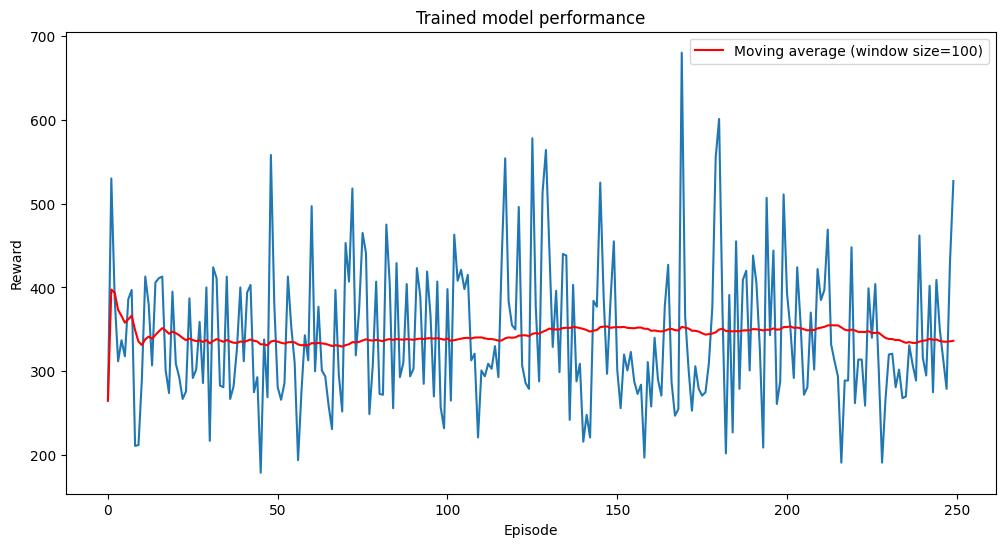

In [6]:
demo(trained=True)